<a href="https://colab.research.google.com/github/meeks627/BeyondAI-KANs-vs-MLPs-Colab-Code/blob/main/Cancer_Dataset_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Necessary Libraries

In [2]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-x_1oq4lm
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-x_1oq4lm
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78208 sha256=31aba51900dcdaf1810cbe384f96b0ae36acf07a79e1ce23827a701a6da909b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-8__alprh/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")

##Models

The models are being called here along with the number of layers, activation function and other hyperparameters needed for the initial run

In [4]:
#MLP Model
mlp = MLPClassifier(hidden_layer_sizes=(5,5,5),
                    max_iter=1000,
                    activation='tanh',
                    learning_rate='adaptive',
                    alpha= 0.1,
                    solver='adam',
                    random_state=42,
                    verbose = False)

#KAN Model
width = [9,5,5,5,2] # should be adjusted based on dataset
kan = KAN(width=width, grid=5, k=3, seed=42)

checkpoint directory created: ./model
saving model version 0.0


#Functions

All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix. The function to plot the graph is also written here.

##Model Functions

In [5]:
def MLP_run(mlp,X_train,y_train,X_test,y_test):
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  criterion = nn.MSELoss()
  start_time = time.time()
  mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
  y_pred_train = mlp.predict(X_train)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))

  y_pred_test = mlp.predict(X_test)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_acc, test_acc, train_loss, test_loss, MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.long)
  y_test = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()
  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(X_train)
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(y_train, predicted)
    train_loss = loss_fn(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.3f}, KAN Train Accuracy: {train_accuracy}')
  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test_tensor, predicted.argmax(1))
    test_loss = loss_fn(predicted, y_test_tensor)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.3f},KAN Test Accuracy: {test_accuracy:.3f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [6]:
def run_models(epochs):
  train_accuracies,test_accuracies,train_losses,test_losses = [],[],[],[]
  execution_time = 0
  for i in range(epochs):
    mlp_model_run = MLP_run(mlp,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor)
    execution_time += mlp_model_run[4]
    train_accuracies.append(mlp_model_run[0])
    test_accuracies.append(mlp_model_run[1])
    train_losses.append(mlp_model_run[2])
    test_losses.append(mlp_model_run[3])
    if (i + 1) % 10 == 0:
      print(f'Epoch [{i+1}/{epochs}],MLP Train Loss: {mlp_model_run[2]:.3f}, MLP Train Accuracy: {mlp_model_run[0]}')
  print()
  for i in range(epochs):
    if (i +1)% 10 == 0:
      print(f'Epoch [{i+1}/{epochs}],MLP Test Loss: {mlp_model_run[3]:.3f}, MLP Test Accuracy: {mlp_model_run[1]}')
  mlp_metrics = [train_accuracies,test_accuracies,train_losses,test_losses]
  print(f'MLP Execution time: {execution_time:.2f} seconds')
  print()
  kan_model_run = KAN_run(kan,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')

  return mlp_metrics,kan_metrics

##Plot Function

In [7]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics

    plt.figure(figsize=(10,6))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(221)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue' )
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='red' )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP Train and Test Accuracy Over Epochs')
    plt.legend()

    # Graph of Test Accuracy for both models over number of epochs
    plt.subplot(222)
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='blue')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('KAN Train and Test Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(223)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [21]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  mlp_classification= classification_report(y_test_tensor, mlp.predict(x_test_tensor))
  kan_classification = classification_report(y_test_tensor, kan(x_test_tensor).argmax(1))
  mlp_confusion = confusion_matrix(y_test_tensor, mlp.predict(x_test_tensor))
  kan_confusion = confusion_matrix(y_test_tensor, kan(x_test_tensor).argmax(1))
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

#Dataset

The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [9]:
url_wisconsin_breast_cancer = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(url_wisconsin_breast_cancer, header=None)
df[10]=df[10].replace(2,0)
df[10]=df[10].replace(4,1)
x = df.drop([6, 10], axis=1).values
y = df[10].values

##Prepare Dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

# Runing the model


Running the models over epochs

Plotting the accuracies and loss over epochs

Calculating other comparison criteria



## Runing each model

In [11]:
epochs = 100
mlp_metrics,kan_metrics = run_models(epochs)

Epoch [10/100],MLP Train Loss: 0.098, MLP Train Accuracy: 0.9021479713603818
Epoch [20/100],MLP Train Loss: 0.069, MLP Train Accuracy: 0.9307875894988067
Epoch [30/100],MLP Train Loss: 0.055, MLP Train Accuracy: 0.9451073985680191
Epoch [40/100],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [50/100],MLP Train Loss: 0.045, MLP Train Accuracy: 0.954653937947494
Epoch [60/100],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [70/100],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [80/100],MLP Train Loss: 0.045, MLP Train Accuracy: 0.954653937947494
Epoch [90/100],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [100/100],MLP Train Loss: 0.050, MLP Train Accuracy: 0.9498806682577565

Epoch [10/100],MLP Test Loss: 0.029, MLP Test Accuracy: 0.9714285714285714
Epoch [20/100],MLP Test Loss: 0.029, MLP Test Accuracy: 0.9714285714285714
Epoch [30/100],MLP Test Loss: 0.029, MLP Test Accuracy: 0.9714285714285714
Epoch

##Plotting Accuracy and Loss function

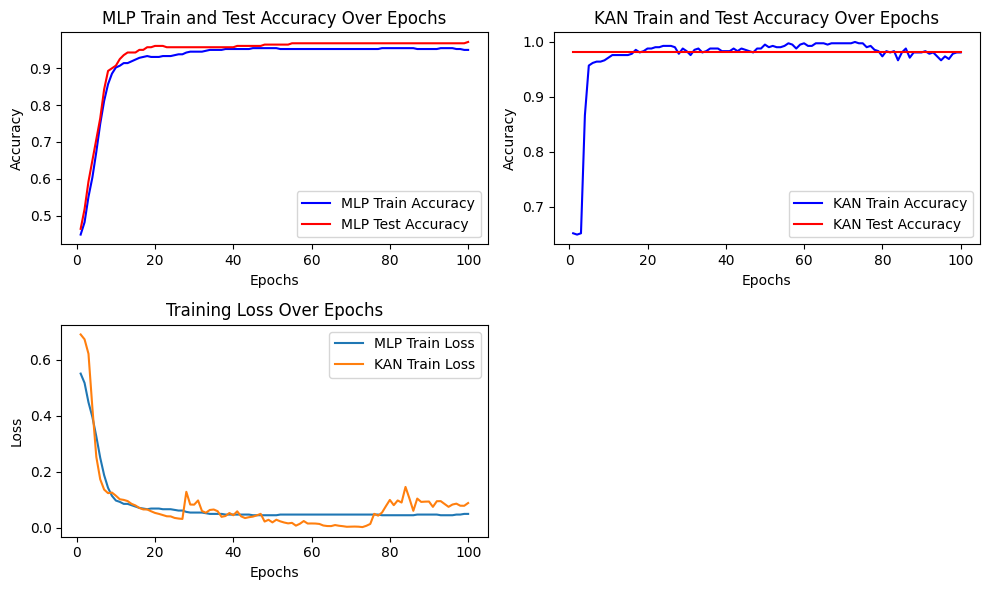

In [12]:
plot_comparison_over_epochs(mlp_metrics, kan_metrics,epochs)

## Calculating the f1 score, precision, recall, and the confusion matrix (how well each model classifies each classes)

In [13]:
criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.97      0.96        95

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

KAN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       185
           1       0.96      0.99      0.97        95

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280

MLP Confusion Matrix:
[[180   5]
 [  3  92]]
KAN Confusion Matrix:
[[181   4]
 [  1  94]]


#Hyperparameter Tunning

In [15]:
param_grid_mlp = {
    'hidden_layer_sizes': [(64,32), (40,25,10), (64,32,16)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.001,0.1],
    'learning_rate':['adaptive','constant']}
start_time = time.time()
mlp = MLPClassifier(max_iter=500, random_state=42)
clfmlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy')
clfmlp.fit(x_train_tensor, y_train_tensor)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Execution time: 1589.66 seconds


In [16]:
print(f"Best accuracy: {clfmlp.best_score_}")
print(f"Best parameters: {clfmlp.best_params_}")

Best accuracy: 0.959380378657487
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'adam'}


# Final Model Run

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.031, MLP Train Accuracy: 0.9689737470167065
Epoch [20/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [30/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [40/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [50/100],MLP Train Loss: 0.031, MLP Train Accuracy: 0.9689737470167065
Epoch [60/100],MLP Train Loss: 0.031, MLP Train Accuracy: 0.9689737470167065
Epoch [70/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [80/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [90/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751
Epoch [100/100],MLP Train Loss: 0.029, MLP Train Accuracy: 0.9713603818615751

Epoch [10/100],MLP Test Loss: 0.025, MLP Test Accuracy: 0.975
Epoch [20/100],MLP Test Loss: 0.025, MLP Test Accuracy: 0.975
Epoch [30/100],MLP Test Loss: 0.025, MLP 

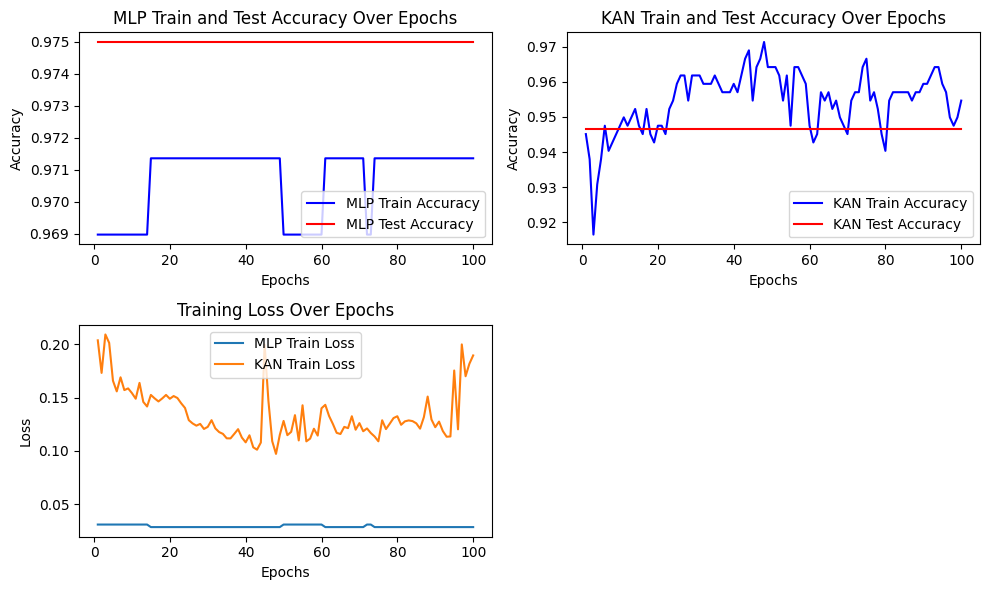

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.96      0.95        95

    accuracy                           0.97       280
   macro avg       0.96      0.97      0.96       280
weighted avg       0.97      0.97      0.97       280

MLP Confusion Matrix:
[[180   5]
 [  4  91]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       185
           1       0.94      0.94      0.94        95

    accuracy                           0.96       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.96      0.96      0.96       280

KAN Confusion Matrix:
[[179   6]
 [  6  89]]


In [22]:
mlp_new = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=500,
                    activation='tanh',
                    learning_rate_init= 0.1,
                    learning_rate='adaptive',
                    alpha= 0.1,
                    solver='adam',
                    random_state=42,
                    verbose = False)

width = [9,19,2]
kan_new= KAN(width=width, grid=3, k=5,noise_scale=1, seed=42)
num_epochs = 100
mlp_metrics_new,kan_metrics_new = run_models(num_epochs)
plot_comparison_over_epochs(mlp_metrics_new, kan_metrics_new,num_epochs)
mlp_new.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_new,kan_new,x_test_tensor,y_test_tensor)